In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy import absolute
from numpy import mean, std

from scipy.stats import uniform, randint

import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
from math import sqrt

from sklearn import metrics, svm, tree
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from skopt.space import Real, Categorical

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay, r2_score, mean_absolute_percentage_error, mean_squared_error, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

# Define Fuctions

In [2]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.style.use('seaborn')    
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
    return

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotDiff(test_set, pred_set):
  pred = pd.DataFrame(pred_set)
  pred = pred.set_index(test_set.index)
  diff = test_set['V'] - pred[0]
  diff = pd.DataFrame(diff)
  plt.figure(figsize = (5, 10))
  sns.boxplot(data=diff).set(title='Boxplot of diff between all voltages and predicted voltages')
  plt.figure()
  sns.histplot(diff).set(title='Diff between all voltages and predicted voltages')
  for i in sorted(test_set['V'].unique()):
    plt.figure()
    sns.histplot(diff[test_set['V'] == i], binwidth=0.001).set(title={'Voltage', i})

def plotCodes(test_set, X_set, pred_set):
  pred = pd.DataFrame(pred_set)
  pred = pred.rename(columns={0: 'predicted_V'})
  pred = pred.set_index(test_set.index)

  diff = test_set['V'] - pred['predicted_V']
  diff = pd.DataFrame(diff)
  diff = diff.rename(columns={0: 'diff'})
  diff = diff.set_index(test_set.index)

  comb = X_set.join(test_set, how='left')
  comb = comb.join(pred, how='left')
  comb = comb.join(diff, how='left')

  zero = comb[comb['code'] == 0]
  rest = comb[(comb['code'] != 31) & (comb['code'] != 0)]
  t = comb[comb['code'] == 31]

  plt.figure()
  sns.histplot(zero['diff'], binwidth=0.01).set(title={'Code 0'})

  plt.figure()
  sns.histplot(t['diff'], binwidth=0.01).set(title={'Code 31'})
  
  plt.figure()
  sns.histplot(rest['diff'], binwidth=0.01).set(title={'Code 1-30'})


def find_con(y_test, X_test, pred):
  comb = y_test.join(pd.DataFrame(pred).set_index(y_test.index))
  df = X_test.join(comb)
  for i in sorted(df['V'].unique()):
    std = df[df['V'] == i][0].to_frame().std()[0] * 1.96
    lower, upper = df[df['V'] == i].mean()[0] - std, df[df['V'] == i].mean()[0] + std
    print('95% sample confidence interval for voltage {}:[{}, {}]'.format(i, lower, upper))

In [3]:
# data pre-processing and modelling functions
def check_overfitting(cv_results, threshold=0.2):
    train_scores = cv_results['mean_train_score']
    val_scores = cv_results['mean_test_score']

    best_index = np.argmin(val_scores)
    train_rmse = -train_scores[best_index]
    val_rmse = -val_scores[best_index]
    rmse_diff = train_rmse - val_rmse

    if rmse_diff > threshold:
        print(f"Warning: Potential overfitting detected! (RMSE Difference: {rmse_diff:.3f})")
    else:
        print(f"No overfitting detected. (RMSE Difference: {rmse_diff:.3f})")

    return best_index

def pipeall_gcv(clf, X, y, params):
    model = TransformedTargetRegressor(regressor=clf, transformer=StandardScaler())

    rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    gcv = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=rmse_scorer, n_jobs=-1,
                       return_train_score=True, error_score='raise')
    gcv.fit(X, y.values.ravel())

    best_index = check_overfitting(gcv.cv_results_)  # check overfitting

    print(f"Best parameters: {gcv.best_params_}")
    print(f"Training RMSE: {-gcv.cv_results_['mean_train_score'][best_index]:.3f}, "
          f"Validation RMSE: {-gcv.cv_results_['mean_test_score'][best_index]:.3f}")

    return gcv

def pipeall_random(clf, X, y, param_distributions, n_iter=5, early_stopping_rounds=5):
    model = TransformedTargetRegressor(regressor=clf, transformer=MinMaxScaler())

    rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Randomized Search
    rcv = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_distributions, 
        n_iter=n_iter,
        cv=KFold(n_splits=5, shuffle=True, random_state=22),
        scoring=rmse_scorer, 
        n_jobs=-1, 
        return_train_score=True, 
        error_score='raise',
    )

    # Early Stopping
    if hasattr(clf, 'early_stopping_rounds'):
        fit_params = {'regressor__early_stopping_rounds': early_stopping_rounds, 
                      'regressor__eval_metric': 'rmse', 
                      'regressor__eval_set': [(X, y)]}
    else:
        fit_params = {}
    
    if isinstance(clf, XGBRegressor):
        xgb_fit_params = {
            k.replace('regressor__', ''): v 
            for k, v in fit_params.items()
        }
        rcv.fit(X, y.values.ravel(), **xgb_fit_params)
    elif hasattr(clf, 'early_stopping_rounds'):
        rcv.fit(X, y.values.ravel(), **fit_params)
    else:
        rcv.fit(X, y.values.ravel())

    # check_overfitting
    best_index = check_overfitting(rcv.cv_results_)

    print(f"Best parameters: {rcv.best_params_}")
    print(f"Training RMSE: {-rcv.cv_results_['mean_train_score'][best_index]:.3f}, "
          f"Validation RMSE: {-rcv.cv_results_['mean_test_score'][best_index]:.3f}")
    
    return rcv

def pipepoly(clf, polyfea, X, y, param_distributions, cv=5, n_iter=5):
    p = Pipeline([("polynomial_features", polyfea),
                  ("scaling", StandardScaler()),
                  ("model", clf)])
    wrapped = TransformedTargetRegressor(regressor=p, transformer=StandardScaler())
    rcv = RandomizedSearchCV(estimator=wrapped, param_distributions=param_distributions,
                                       cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1,
                                       return_train_score=True, n_iter=n_iter, random_state=42)
    rcv.fit(X, y.values.ravel())

    return rcv

# Data Preprocessing

In [4]:
pvt_ori = pd.read_csv('./data/pvt_tall_v3.csv')
mc_ori = pd.read_csv('./data/mc.csv')

# Combine 2 datasets
df_ori = pd.concat([pvt_ori, mc_ori]) 

In [5]:
df_ori.dropna(axis=1, inplace=True)
#mc_ori.dropna(axis=1, inplace=True)

In [6]:
df = df_ori.copy()
#mc = mc_ori.copy()
#mc = mc.rename(columns={'MC': 'P'})
enc = OrdinalEncoder()
#enc.fit(df[['P']])
#df[['P']] = enc.transform(df[['P']])
#df[['P']] = df[['P']] + 31
#df = df.append(mc)
df.reset_index(inplace=True)
df

,index,Unnamed: 0,t,v,freq,T,V,p'
0,0,0,-40.0,1.350,638400000,-40.0,1.4,681900000
1,1,1,-40.0,1.350,638400000,-35.0,1.4,676900000
2,2,2,-40.0,1.350,638400000,-30.0,1.4,672300000
3,3,3,-40.0,1.350,638400000,-25.0,1.4,667900000
4,4,4,-40.0,1.350,638400000,-20.0,1.4,663200000
...,...,...,...,...,...,...,...,...
1393723,124435,2069,125.0,1.630,1050000000,25.0,1.5,1028000000
1393724,124436,2070,125.0,1.635,1045000000,25.0,1.5,1028000000
1393725,124437,2071,125.0,1.640,1041000000,25.0,1.5,1028000000
1393726,124438,2072,125.0,1.645,1036000000,25.0,1.5,1028000000


In [7]:
df.columns[:]

Index(['index', 'Unnamed: 0', 't', 'v', 'freq', 'T', 'V', 'p''], dtype='object')

In [8]:
# # Get dummies for the specified columns
# df_dummies = pd.get_dummies(df[['t','v','T','V']])

# # Normalize the specified columns
# scaler = MinMaxScaler()
# df_norm = pd.DataFrame(scaler.fit_transform(df[['freq','p\'']]), columns=['freq','p\''])

# # Concatenate the dummy dataframe and the normalized dataframe
# df_processed = pd.concat([df_dummies, df_norm], axis=1)
# df = df_processed

In [9]:
# Get dummies for the specified columns
df_other = df[['t','v','T','V']]

# Normalize the specified columns
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[['freq','p\'']]), columns=['freq','p\''])

# Concatenate the dummy dataframe and the normalized dataframe
df_processed = pd.concat([df_other, df_norm], axis=1)
df = df_processed

In [10]:
df

,t,v,T,V,freq,p'
0,-40.0,1.350,-40.0,1.4,0.118305,0.145873
1,-40.0,1.350,-35.0,1.4,0.118305,0.139909
2,-40.0,1.350,-30.0,1.4,0.118305,0.134423
3,-40.0,1.350,-25.0,1.4,0.118305,0.129175
4,-40.0,1.350,-20.0,1.4,0.118305,0.123569
...,...,...,...,...,...,...
1393723,125.0,1.630,25.0,1.5,0.565454,0.558683
1393724,125.0,1.635,25.0,1.5,0.560022,0.558683
1393725,125.0,1.640,25.0,1.5,0.555676,0.558683
1393726,125.0,1.645,25.0,1.5,0.550244,0.558683


In [11]:
# Split

# X = comb[['code', 'N', 'T', 'N_c', 'T_c', 'V_c']].copy()
X = df[['t', 'v', "p'", 'T', 'V']].copy()

# y = comb[['V']].copy()
y = df[['freq']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22, stratify=df['V'], shuffle=True)

train_data = pd.concat([X_train, y_train], axis=1)  
test_data = pd.concat([X_test, y_test], axis=1)  
test_data

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(975609, 5)
(418119, 5)
(975609, 1)
(418119, 1)


In [12]:
y_train

,freq
1173499,0.445845
166802,0.314503
1324682,0.596958
143852,0.215426
1024900,0.219555
...,...
419911,0.982618
1141956,0.417490
556564,0.433895
606765,0.415644


# Model Training and Validation

## XGBoost

In [13]:
# random
xgb_params = {
    'regressor__n_estimators': randint(10, 50), 
    'regressor__learning_rate': uniform(0.1, 1), 
    'regressor__max_depth': randint(1, 20),
    'regressor__reg_lambda': uniform(20, 100),
    'regressor__reg_alpha': uniform(20, 100),
}

xgb_rcv = pipeall_random(XGBRegressor(random_state=22), X_train, y_train, xgb_params)
print("Mean RMSE for XGBoost:", abs(xgb_rcv.best_score_)) 

[0]	validation_0-rmse:0.14118


c:\Users\ZengF\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\ZengF\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:0.10022
[2]	validation_0-rmse:0.07281
[3]	validation_0-rmse:0.05462
[4]	validation_0-rmse:0.04304
[5]	validation_0-rmse:0.03548
[6]	validation_0-rmse:0.03049
[7]	validation_0-rmse:0.02759
[8]	validation_0-rmse:0.02580
[9]	validation_0-rmse:0.02461
[10]	validation_0-rmse:0.02385
[11]	validation_0-rmse:0.02326
[12]	validation_0-rmse:0.02268
[13]	validation_0-rmse:0.02236
No overfitting detected. (RMSE Difference: 0.000)
Best parameters: {'regressor__learning_rate': 0.3227277500759471, 'regressor__max_depth': 17, 'regressor__n_estimators': 14, 'regressor__reg_alpha': 48.2972277473302, 'regressor__reg_lambda': 65.13339438364096}
Training RMSE: 0.074, Validation RMSE: 0.074
Mean RMSE for XGBoost: 0.023077427007733287


In [14]:
# XGBoost Model
xgb_best_model = xgb_rcv.best_estimator_
xgb_pred = xgb_best_model.predict(X_train)

# Evaluate XGBoost Model
print("mse:", mean_squared_error(y_train, xgb_pred))
print("rmse:", mean_squared_error(y_train, xgb_pred, squared=False))
print("mae:", mean_absolute_error(y_train, xgb_pred))
print("mape:", mean_absolute_percentage_error(y_train, xgb_pred))
print("r2:", r2_score(y_train, xgb_pred))

mse: 0.0005000044746315879
rmse: 0.02236077983057809
mae: 0.013451156507782145
mape: 12022946713.50145
r2: 0.9877704977989197


## LightGBM

In [15]:
import lightgbm as lgb

In [17]:
# random search
lgb_params = {
    'regressor__n_estimators': randint(10, 50),
    'regressor__learning_rate': uniform(0.1, 1), 
    'regressor__num_leaves': randint(1, 20),
    'regressor__reg_lambda': uniform(20, 100),
    'regressor__reg_alpha': uniform(20, 100),
    'regressor__min_child_weight': randint(1, 20)
}

lgb_rcv = pipeall_random(lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=22), X_train, y_train, lgb_params)
print("Mean RMSE for LightGBM:", abs(lgb_rcv.best_score_)) 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 975609, number of used features: 5
[LightGBM] [Info] Start training from score 0.383244
No overfitting detected. (RMSE Difference: -0.000)
Best parameters: {'regressor__learning_rate': 0.33674937800708316, 'regressor__min_child_weight': 6, 'regressor__n_estimators': 39, 'regressor__num_leaves': 15, 'regressor__reg_alpha': 53.61077911630495, 'regressor__reg_lambda': 65.50556176716094}
Training RMSE: 0.038, Validation RMSE: 0.038
Mean RMSE for LightGBM: 0.024386484399693018


In [18]:
# LightGBM Model
lgb_best_model = lgb_rcv.best_estimator_
lgb_pred = lgb_best_model.predict(X_train)

# Evaluate LightGBM Model
print("mse:", mean_squared_error(y_train, lgb_pred))
print("rmse:", mean_squared_error(y_train, lgb_pred, squared=False))
print("mae:", mean_absolute_error(y_train, lgb_pred))
print("mape:", mean_absolute_percentage_error(y_train, lgb_pred))
print("r2:", r2_score(y_train, lgb_pred))

mse: 0.0005907387320365773
rmse: 0.02430511740429528
mae: 0.01566496461594307
mape: 6479369688.954944
r2: 0.9855512765206077


## Random Forest

In [19]:
# random
rf_params = {
    'regressor__max_depth': randint(2, 8),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 20), 
    'regressor__n_estimators': randint(50, 100),
    'regressor__max_features': ['sqrt'] # for early stopping
}

# Perform grid search cross-validation for RF
rf_rcv = pipeall_random(RandomForestRegressor(random_state=22), X_train, y_train, rf_params)
print("Mean RMSE for RF:", abs(rf_rcv.best_score_))


No overfitting detected. (RMSE Difference: -0.000)
Best parameters: {'regressor__max_depth': 6, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 6, 'regressor__n_estimators': 75}
Training RMSE: 0.125, Validation RMSE: 0.125
Mean RMSE for RF: 0.055030494038781776


In [20]:
# Fit RF with best parameters
rf_best_model = rf_rcv.best_estimator_
rf_pred = rf_best_model.predict(X_train)

# Evaluate Random Forest Model
print("mse:", mean_squared_error(y_train, rf_pred))
print("rmse:", mean_squared_error(y_train, rf_pred, squared=False))
print("mae:", mean_absolute_error(y_train, rf_pred))
print("mape:", mean_absolute_percentage_error(y_train, rf_pred))
print("r2:", r2_score(y_train, rf_pred))

mse: 0.003003239622210942
rmse: 0.05480182134027064
mae: 0.041658138989683964
mape: 31216746272.37955
r2: 0.9265445509318767


## Poly LR

In [21]:
# # test vs train error
# tests = []
# trains = []
# lst = [i for i in range(1, 4, 1)]
# for i in lst:
#   polynomial_features = PolynomialFeatures(degree=i, include_bias=False)
#   pipeline = Pipeline([("polynomial_features", polynomial_features),
#                           ("scaling", StandardScaler()),
#                               ("linear_regression", LinearRegression())])
#   wrapped = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
#   wrapped.fit(X_train, y_train)
#   plr_pred = wrapped.predict(X_test)
#   rmse = sqrt(mean_squared_error(y_test, plr_pred))
#   tests.append(rmse)

#   pred3 = wrapped.predict(X_train)
#   rmse3 = sqrt(mean_squared_error(y_train, pred3))
#   trains.append(rmse3)

# print(tests)
# print(trains)

# plt.style.use('seaborn')
# plt.plot(lst, trains, label = 'Training error', marker='o')
# plt.plot(lst, tests, label = 'Test error', marker='o')
# plt.ylabel('RMSE', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves for a polynomial regression model', fontsize = 18, y = 1.03)
# plt.legend()
# plt.ylim(0, 0.2)

In [22]:
# # Poly LR Cross Validation
# for i in range(1,4, 1):
#     polynomial_features = PolynomialFeatures(degree=i, include_bias=False)
#     linear_regression = LinearRegression()
#     pipeline = Pipeline([("polynomial_features", polynomial_features),
#                          ("scaling", StandardScaler()),
#                             ("model", linear_regression)])
#     wrapped = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

#     cv = KFold(n_splits=10, shuffle=True, random_state=22)
#     scores = cross_val_score(wrapped, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    
#     rmse_scores = absolute(scores)
    
#     cross_validation_score_mse = rmse_scores.mean()
    
#     print("RMSE by cross validation of polynomial degree {} regression: {}".format(i, str(cross_validation_score_mse)))

In [23]:
plr_features = PolynomialFeatures(degree=3, include_bias=False)
plr_param = {'regressor__model__alpha': uniform(10, 50)}
plr_rcv = pipepoly(Ridge(), plr_features, X_train, y_train, plr_param)

print(f"Best parameters: {plr_rcv.best_params_}")

Best parameters: {'regressor__model__alpha': 17.800932022121827}


In [24]:
plr_best_model = plr_rcv.best_estimator_
plr_pred = plr_best_model.predict(X_train)

print("mse:", mean_squared_error(y_train, plr_pred))
print("rmse:", mean_squared_error(y_train, plr_pred, squared=False))
print("mae:", mean_absolute_error(y_train, plr_pred))
print("mape:", mean_absolute_percentage_error(y_train, plr_pred))
print("r2:", r2_score(y_train, plr_pred))

mse: 0.0017356886453546885
rmse: 0.041661596769143265
mae: 0.021746956656336847
mape: 7209090938.728448
r2: 0.9575472473311635


In [25]:
# plt.style.use('seaborn')
# plt.scatter(y_train, plr_pred)
# plt.xlabel('actual voltage')
# plt.ylabel('predicted voltage')

## SVM

In [26]:
# # grid search for SVR
# svm_params = {
#     'regressor__C': [1, 10],
#     'regressor__kernel': ['rbf'],
#     'regressor__gamma': [0.01, 0.1],
# }

# # Create SVR regressor
# svr = SVR()

# # Perform random search cross-validation for SVR
# svr_rcv = pipeall_random(svr, X_train, y_train, svm_params)

# # Print best parameters and mean RMSE for SVR
# print("Mean RMSE for SVR:", abs(svr_rcv.best_score_))

In [27]:
# # Fit SVR with best parameters
# svr_best_model = svr_rcv.best_estimator_
# svr_pred = svr_best_model.predict(X_train)

# # Evaluate SVR model performance
# print("mse:", mean_squared_error(y_train, svr_pred))
# print("rmse:", mean_squared_error(y_train, svr_pred, squared=False))
# print("mae:", mean_absolute_error(y_train, svr_pred))
# print("mape:", mean_absolute_percentage_error(y_train, svr_pred))
# print("r2:", r2_score(y_train, svr_pred))

## Models Comparison

In [28]:
def get_num_params(model):
    """Gets the number of parameters in a model."""
    if isinstance(model, TransformedTargetRegressor):
        model = model.regressor_
    if isinstance(model, Pipeline):
        # For Polynomial Regression, consider the polynomial degree
        degree = model.named_steps['polynomial_features'].degree
        num_features = model.named_steps['scaling'].n_features_in_
        num_params = (degree + 1) * num_features  # Parameters in polynomial expansion + intercept
    elif isinstance(model, (RandomForestRegressor, XGBRegressor)):
        num_params = model.get_params()['n_estimators']  # Number of trees
    elif isinstance(model, SVR):
        num_params = 3  # C, gamma, and intercept
    elif isinstance(model, lgb.LGBMRegressor):
        # LightGBM
        num_params = model.n_estimators  # Approximate the number of parameters by the number of trees
    else:
        num_params = len(model.coef_) + 1  # Coefficients + intercept for linear models

    return num_params

def calculate_aic_bic(y_true, y_pred, num_params, num_obs):
  """Calculates AIC and BIC"""
  residuals = y_true - y_pred
  sse = np.sum(residuals**2)  # Sum of squared errors
  log_likelihood = -num_obs / 2 * np.log(2 * np.pi * sse / num_obs) - num_obs / 2
  aic = -2 * log_likelihood + 2 * num_params
  bic = -2 * log_likelihood + num_params * np.log(num_obs)
  return aic, bic

def evaluate_models(y_train, y_pred, models, model_name):
    metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'AIC', 'BIC']
    results = []

    for model, pred_values in zip(models, y_pred):
        mse = mean_squared_error(y_train, pred_values)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_train, pred_values)
        mape = mean_absolute_percentage_error(y_train, pred_values)
        r2 = r2_score(y_train, pred_values)

        num_params = get_num_params(model)
        aic, bic = calculate_aic_bic(y_train.values.ravel(), pred_values, num_params, len(y_train))

        results.append([mse, rmse, mae, mape, r2, aic, bic])

    # Create DataFrame
    results_df = pd.DataFrame(results, index=model_name, columns=metrics)

    # Print results
    print("Models Comparison:")

    return results_df

def plot_learning_curves(X, y, estimator, model_name, cv=5, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator,
        X, y.values.ravel(),
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring='neg_root_mean_squared_error'
    )
    
    train_scores_mean = -train_scores.mean(axis=1)
    valid_scores_mean = -valid_scores.mean(axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training RMSE')
    plt.plot(train_sizes, valid_scores_mean, label='Validation RMSE')
    plt.xlabel('Training Examples')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curves for {model_name}')
    plt.legend()
    plt.show()

In [29]:
y_pred = [plr_pred, rf_pred, xgb_pred, lgb_pred]
models = [plr_best_model, rf_best_model, xgb_best_model, lgb_best_model]
model_name = ['Poly LR', 'Random Forest', 'XGBoost', 'LightGBM']

evaluate_models(y_train, y_pred, models, model_name)

# y_pred = [plr_pred, rf_pred, xgb_pred, svr_pred, lgb_pred]
# models = [plr_best_model, rf_best_model, xgb_best_model, svr_best_model, lgb_best_model]
# model_name = ['Poly LR', 'Random Forest', 'XGBoost', 'SVM', 'LightGBM']

Models Comparison:


,MSE,RMSE,MAE,MAPE,R2,AIC,BIC
Poly LR,0.001736,0.041662,0.021747,7.209091e+09,0.957547,-3.432215e+06,-3.429621e+06
Random Forest,0.003003,0.054802,0.041658,3.121675e+10,0.926545,-2.897591e+06,-2.896706e+06
XGBoost,0.000500,0.022361,0.013451,1.202295e+10,0.987770,-4.646814e+06,-4.646649e+06
LightGBM,0.000591,0.024305,0.015665,6.479370e+09,0.985551,-4.484074e+06,-4.483614e+06


In [30]:
# for model, name in zip(models, model_name):
#plot_learning_curves(X_train, y_train, model, name)

# Model Testing

In [31]:
def predict_targets(X, models):
    y_pred = []
    
    for model in models:
        predictions = model.predict(X)
        y_pred.append(predictions)
    
    return y_pred

In [32]:
evaluate_models(y_test, predict_targets(X_test, models), models, model_name)

Models Comparison:


,MSE,RMSE,MAE,MAPE,R2,AIC,BIC
Poly LR,0.001733,0.041627,0.021714,6.770648e+09,0.957678,-1.471392e+06,-1.468985e+06
Random Forest,0.003001,0.054781,0.041637,2.982551e+10,0.926705,-1.242057e+06,-1.241236e+06
XGBoost,0.000504,0.022451,0.013471,1.125584e+10,0.987689,-1.988098e+06,-1.987945e+06
LightGBM,0.000592,0.024336,0.015683,6.124743e+09,0.985535,-1.920635e+06,-1.920209e+06


# Save Models

In [33]:
# import os
# from datetime import datetime
# from pickle import dump

# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# model_dir = f"models/{timestamp}"
# os.makedirs(model_dir, exist_ok=True)  

# # save models
# dump(wrapped, open(f"{model_dir}/plr_TVC1.pkl", 'wb'))  
# dump(rf_best_model, open(f"{model_dir}/rf_TVC1.pkl", 'wb'))
# dump(xgb_best_model, open(f"{model_dir}/xgb_TVC1.pkl", 'wb'))
# dump(svr_gcv.best_estimator_, open(f"{model_dir}/svr_TVC1.pkl", 'wb'))

# Testing Script

In [34]:
pvt_ori = pd.read_csv('data/pvt_tall_v3.csv')
pvt_ori = pvt_ori.drop(pvt_ori.columns[0], axis=1).reset_index(drop=True)

mc_ori = pd.read_csv('data/mc.csv')
mc_ori = mc_ori.drop(mc_ori.columns[0], axis=1).reset_index(drop=True)

In [35]:
print("df description:\n", pvt_ori.describe())
print("\nmc description:\n", mc_ori.describe())

df description:
                   t             v          freq             T             V  \
count  1.269288e+06  1.269288e+06  1.269288e+06  1.269288e+06  1.269288e+06   
mean   4.250000e+01  1.500000e+00  8.793197e+08  4.250000e+01  1.500000e+00   
std    4.905356e+01  8.803412e-02  1.920958e+08  4.905356e+01  8.164969e-02   
min   -4.000000e+01  1.350000e+00  5.295000e+08 -4.000000e+01  1.400000e+00   
25%    0.000000e+00  1.425000e+00  7.327750e+08  0.000000e+00  1.400000e+00   
50%    4.250000e+01  1.500000e+00  8.605000e+08  4.250000e+01  1.500000e+00   
75%    8.500000e+01  1.575000e+00  9.930500e+08  8.500000e+01  1.600000e+00   
max    1.250000e+02  1.650000e+00  1.450000e+09  1.250000e+02  1.600000e+00   

                 p'  
count  1.269288e+06  
mean   8.796057e+08  
std    1.902332e+08  
min    5.596000e+08  
25%    7.326500e+08  
50%    8.610500e+08  
75%    9.863000e+08  
max    1.398000e+09  

mc description:
                freq              t              v      

In [36]:
def plot_column_distributions(pvt_ori, mc_ori):
    for col in pvt_ori.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(pvt_ori[col], bins=20, alpha=0.5, label='pvt_ori')
        plt.hist(mc_ori[col], bins=20, alpha=0.5, label='mc_ori')
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(axis='y', alpha=0.75)
        plt.show()

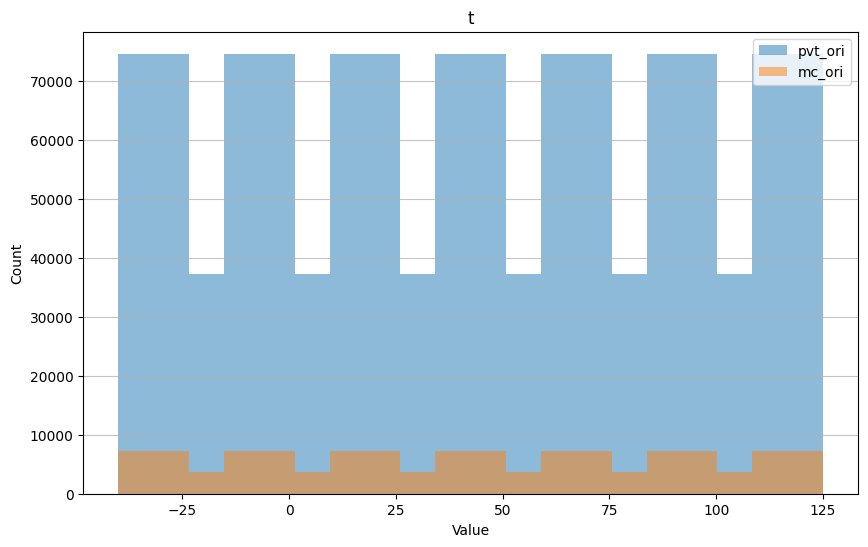

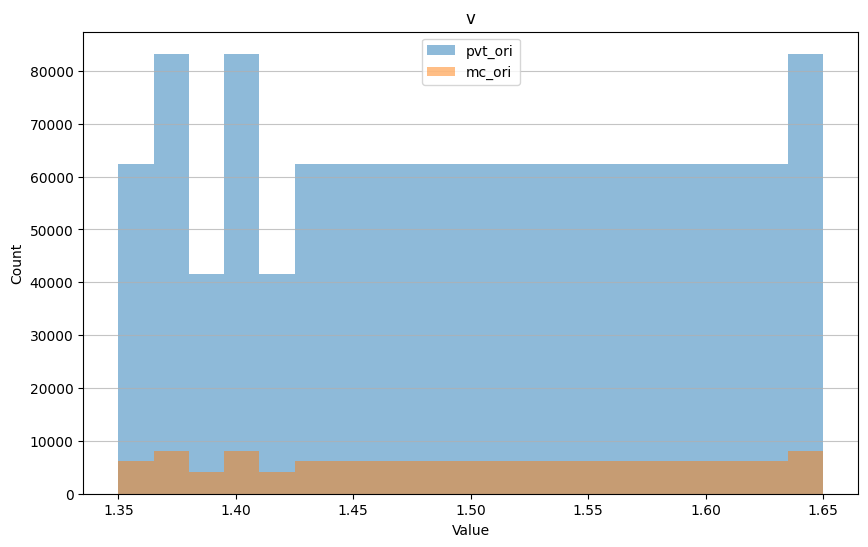

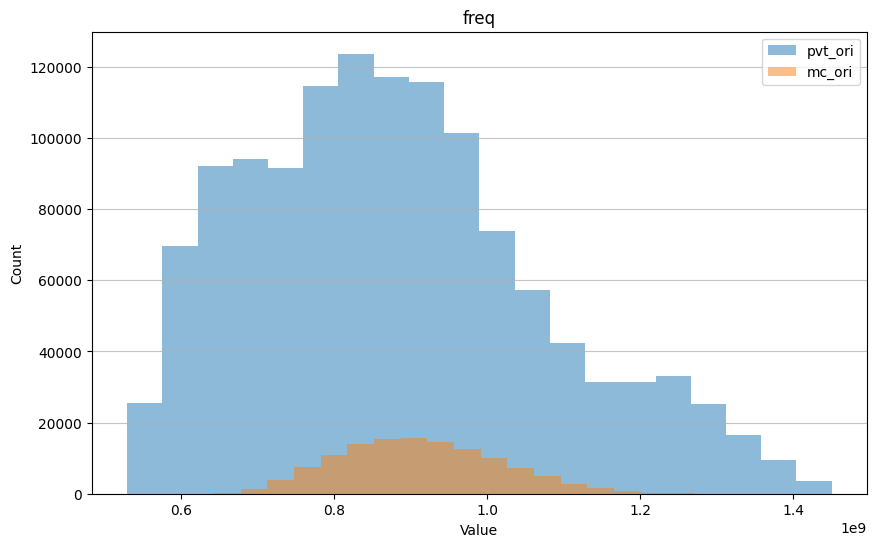

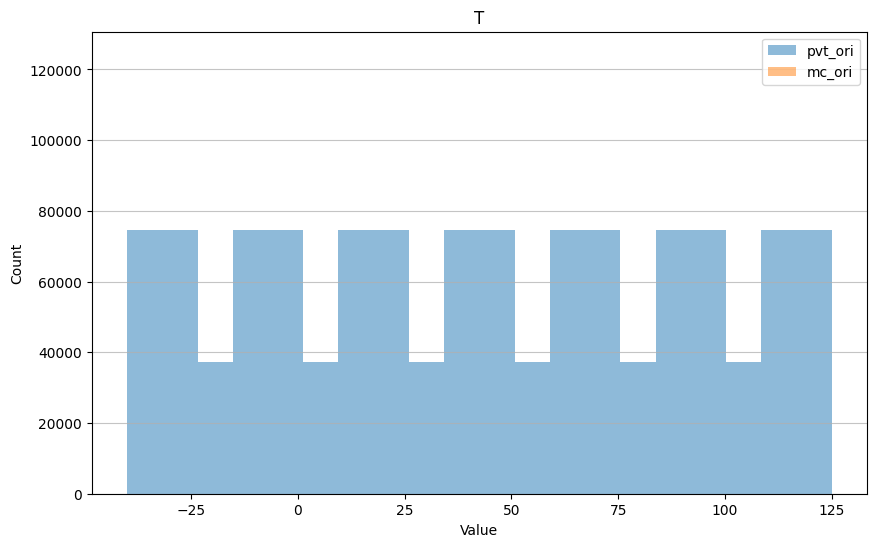

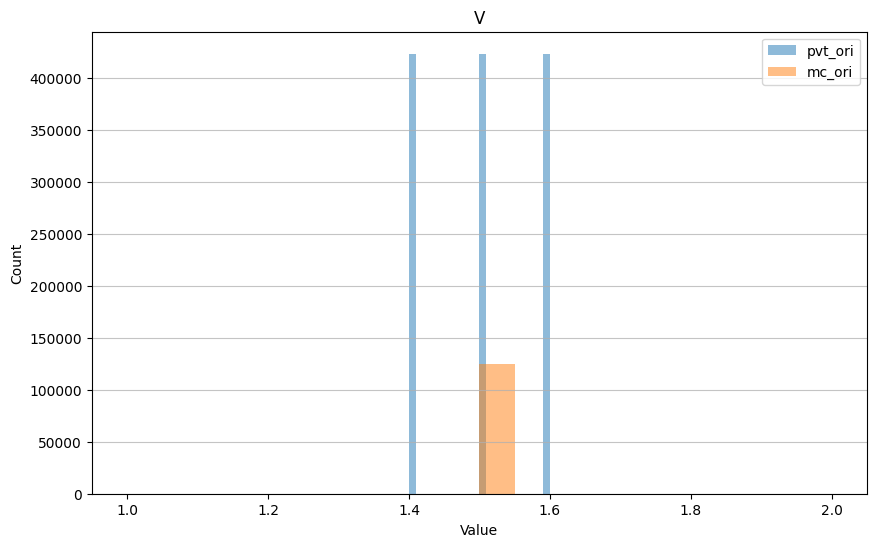

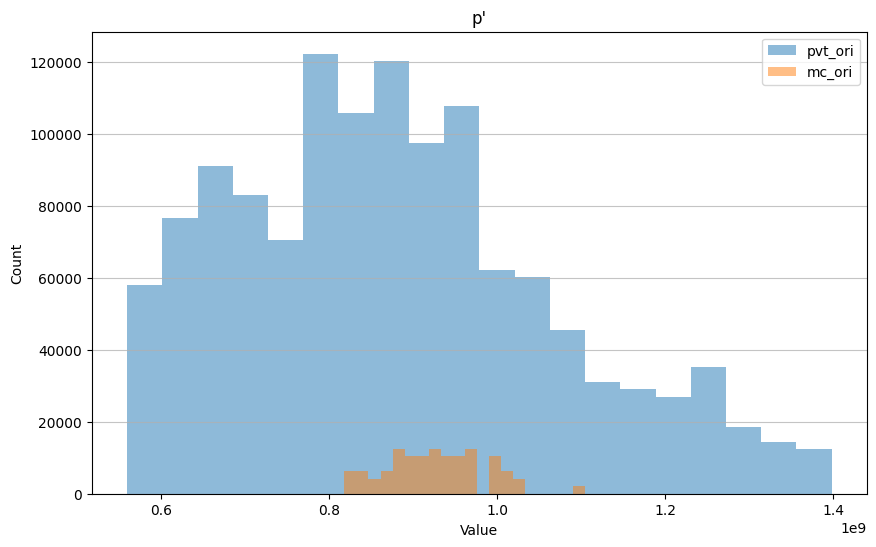

In [37]:
plot_column_distributions(pvt_ori, mc_ori)

c:\Users\ZengF\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


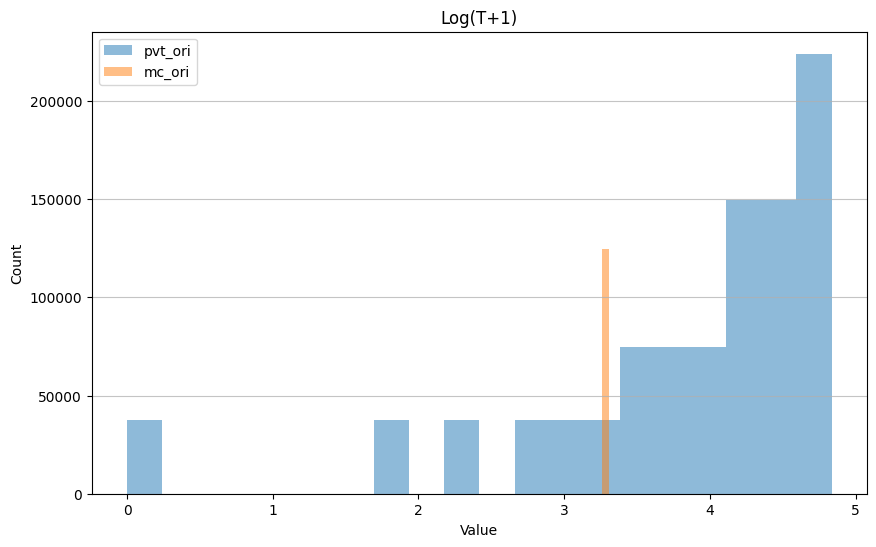

In [38]:
plt.figure(figsize=(10, 6))

# log transform
log_pvt_ori_T = np.log1p(pvt_ori['T'])
log_mc_ori_T = np.log1p(mc_ori['T'])

plt.hist(log_pvt_ori_T, bins=20, alpha=0.5, label='pvt_ori')
plt.hist(log_mc_ori_T, bins=20, alpha=0.5, label='mc_ori')

plt.title('Log(T+1)')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [39]:
# fig, axes = plt.subplots(ncols=2, figsize=(16,4))
# pvt_ori['freq'].plot(kind='density', ax=axes[0], label='df')
# mc_ori['freq'].plot(kind='density', ax=axes[1], label='mc')
# plt.show()

In [40]:
# from scipy.stats import ks_2samp, mannwhitneyu

# # K-S test
# print(ks_2samp(pvt_ori['v'], mc_ori['v']))